# NLPD

In [1]:
!pip install https://github.com/google-research/perceptual-quality/archive/master.zip
from perceptual_quality import nlpd

     - 45.3 kB 22.6 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for perceptual-quality: filename=perceptual_quality-0.1.dev0-py3-none-any.whl size=42291 sha256=4485ae1366ed4b8a72cf79f6ab6188a46d182c251e4bd91a11f4e95580b99fb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-9k6jqf2f/wheels/64/d0/0b/4f1eeb6c2393c1c44ff6cc067539bddd55cac357e7c39291b4
Successfully built perceptual-quality


# import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import display
import torchaudio
import torch
import torchaudio.transforms as T

# Audio

In [12]:
audio_path = 'ori0.wav'
samples, sample_rate = torchaudio.load(audio_path)
re48 = torchaudio.transforms.Resample(orig_freq=48000,new_freq=16000)
audio = re48(samples).mean(axis=0)

print(audio.shape)

window_size = 1024
hop_size = 260
num_mels = 256
reduced_sample_rate = 16000

transform = torchaudio.transforms.MelSpectrogram(n_mels=num_mels,
            n_fft=window_size,
            win_length=window_size,
            hop_length=hop_size,
            power=1,
            center=False,
            sample_rate=reduced_sample_rate,
            f_min=0,
            f_max=reduced_sample_rate / 2,
            window_fn=torch.hann_window,
            mel_scale='htk',
            norm=None)

mel_spec = transform(audio)

print(mel_spec.shape)

torch.Size([67328])
torch.Size([256, 256])


In [13]:
# mel_spec_mono = mel_spec.mean(axis=0)
# mel_spec_mono.shape
print(mel_spec.min(),mel_spec.max())
mel_spec_mono = np.log(mel_spec+10e-3)

tensor(0.) tensor(104.8741)


In [14]:
Max = mel_spec_mono.max()
min = mel_spec_mono.min()
print(min,Max)

mel_spec_proc = (mel_spec_mono-min)/(Max-min)

MM = mel_spec_proc.max()
mm = mel_spec_proc.min()
print(mm,MM)


tensor(-4.6052) tensor(4.6529)
tensor(0.) tensor(1.)


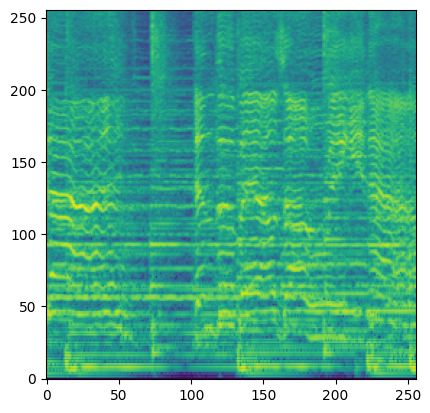

In [15]:
plt.imshow(mel_spec_proc,origin='lower')

In [16]:
x_np = np.reshape(mel_spec_proc,(1,1,mel_spec_proc.shape[0],mel_spec_proc.shape[1]))
x_np.shape

torch.Size([1, 1, 256, 256])

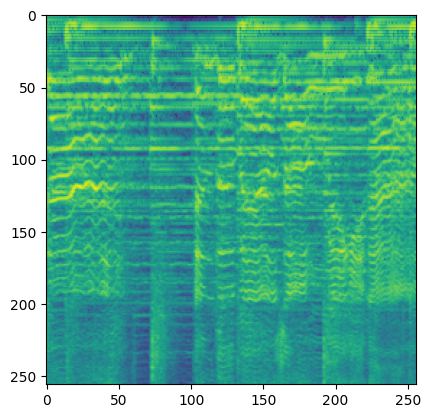

In [17]:
plt.imshow(np.transpose(x_np[0], (1, 2, 0)),vmin=0,vmax=1)

## Optimize the spectogram

0.07556416


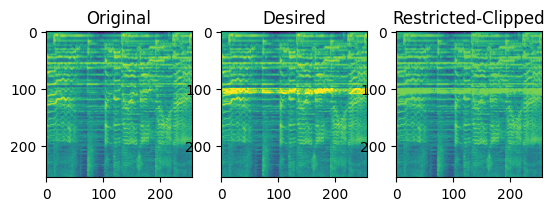

In [18]:
# Generate restricted image

min_audio = 0 # min
Max_audio = 0.8 # max

################
x_np_aux2 = np.float32(x_np.clone())

# Desired
# At a particular frequency we would like to listen cero amount
x_np_aux2[:,:,100:110,:] = 1.5*x_np_aux2[:,:,100:110,:]

# With the restrictions
x_np_aux2_noise = np.float32(np.clip(np.float32(x_np_aux2.copy()),min_audio,Max_audio))
Im_noisy_ori = np.transpose(x_np_aux2_noise[0], (1, 2, 0))

plt.subplot(1,3,1)
plt.imshow(np.transpose(x_np[0], (1, 2, 0)),vmin=0,vmax=1)
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(np.transpose(x_np_aux2[0], (1, 2, 0)),vmin=0,vmax=1)
plt.title('Desired')
plt.subplot(1,3,3)
plt.imshow(np.transpose(x_np_aux2_noise[0], (1, 2, 0)),vmin=0,vmax=1)
plt.title('Restricted-Clipped')
print( np.mean(nlpd.nlpd(tf.convert_to_tensor(np.transpose((x_np_aux2[0])*255, (1, 2, 0))), tf.convert_to_tensor(np.transpose((x_np_aux2_noise[0])*255, (1, 2, 0))),3)))

In [19]:

lr = 50000
N = 2500

nnn_noisy_up = np.zeros((N,))

for ii in range(N):

    tf.config.run_functions_eagerly(True)

    A = tf.convert_to_tensor(np.transpose(x_np_aux2[0]*255, (1, 2, 0)))
    B = tf.convert_to_tensor(np.transpose(x_np_aux2_noise[0]*255, (1, 2, 0)))

    B_aux = np.transpose(x_np_aux2_noise[0]*255, (1, 2, 0))

    with tf.GradientTape() as tape:
        tape.watch(B)
        y_hat = tf.reduce_mean(nlpd.nlpd(A, B, 3))

    grads = tape.gradient(y_hat, B)

    B_aux2 = B_aux - lr * grads.numpy()

    B_aux3 = (B_aux2/255)

    x_np_aux2_noise[0] = np.transpose(np.float32(np.clip(B_aux3,0,1)), (2, 0, 1))

    # Impose restrictions

    x_np_aux2_noise = np.float32(np.clip(x_np_aux2_noise,min_audio,Max_audio))

    # Calculs

    nnn_noisy_up[ii] = np.mean(nlpd.nlpd(tf.convert_to_tensor(np.transpose((x_np_aux2[0])*255, (1, 2, 0))), tf.convert_to_tensor(np.transpose((x_np_aux2_noise[0])*255, (1, 2, 0))),3))

    print(y_hat.numpy(),ii,np.round(nnn_noisy_up[ii],5))

Im_noisy_opt_nlpd = np.transpose(x_np_aux2_noise[0], (1, 2, 0))

0.07556416 0 0.07539
0.075386904 1 0.07521
0.075211756 2 0.07504
0.07503881 3 0.07487
0.07486809 4 0.0747
0.074699625 5 0.07453
0.07453344 6 0.07437
0.07436952 7 0.07421
0.074207686 8 0.07405
0.074047804 9 0.07389
0.07388986 10 0.07373
0.07373376 11 0.07358
0.07357962 12 0.07343
0.07342723 13 0.07328
0.07327647 14 0.07313
0.07312734 15 0.07298
0.07297978 16 0.07283
0.07283366 17 0.07269
0.07268902 18 0.07255
0.0725457 19 0.0724
0.07240366 20 0.07226
0.072263025 21 0.07212
0.072123714 22 0.07199
0.07198576 23 0.07185
0.071848996 24 0.07171
0.0717134 25 0.07158
0.07157889 26 0.07145
0.07144556 27 0.07131
0.07131341 28 0.07118
0.07118239 29 0.07105
0.07105248 30 0.07092
0.070923544 31 0.0708
0.070795625 32 0.07067
0.070668794 33 0.07054
0.07054296 34 0.07042
0.07041815 35 0.07029
0.070294276 36 0.07017
0.07017128 37 0.07005
0.07004918 38 0.06993
0.06992794 39 0.06981
0.06980758 40 0.06969
0.069688044 41 0.06957
0.06956927 42 0.06945
0.069451265 43 0.06933
0.06933409 44 0.06922
0.06921778 

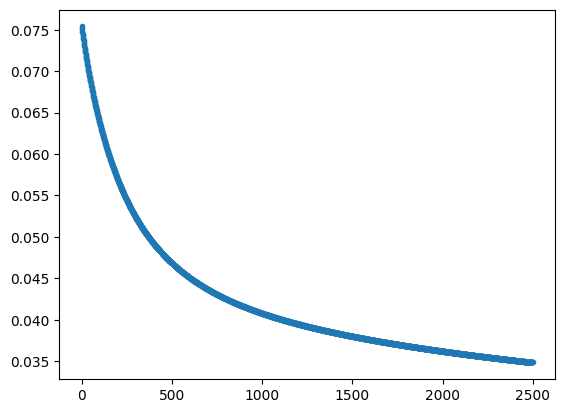

In [20]:
plt.plot(nnn_noisy_up,'.-')

<ipython-input-21-ded01c2d4c3b>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


(-0.5, 255.5, -0.5, 255.5)

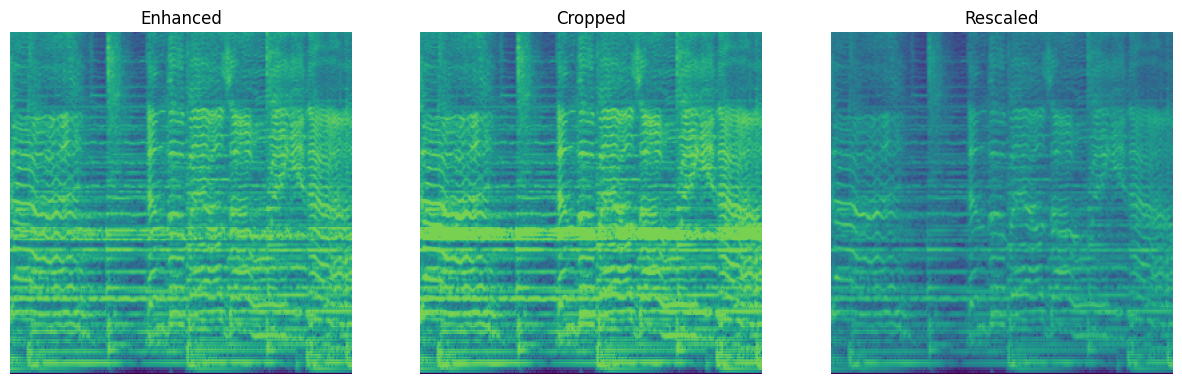

In [21]:
plt.subplots(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(Im_noisy_opt_nlpd,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(Im_noisy_ori,vmin=0,vmax=1,origin='lower')
plt.title('Cropped')
plt.axis('off')
plt.subplot(1,3,3)

im_scaled = mel_spec_proc*(Max_audio-min_audio)+min_audio
plt.imshow(im_scaled,vmin=0,vmax=1,origin='lower')
plt.title('Rescaled')
plt.axis('off')

In [22]:
print(Im_noisy_opt_nlpd.min(),Im_noisy_opt_nlpd.max())
print(Im_noisy_ori.min(),Im_noisy_ori.max())
print(im_scaled.min(),im_scaled.max())

0.0 0.8
0.0 0.8012588
tensor(0.) tensor(0.8000)


## Playback

In [23]:
window_size = 1024
hop_size = 260
n_mels = 256
reduced_sample_rate = 16000
size = 256

griffinlim = T.GriffinLim(n_fft=window_size,hop_length=hop_size,power=1,n_iter=500)
invmel = T.InverseMelScale(n_stft=(window_size//2)+1, n_mels=size, sample_rate=reduced_sample_rate, driver='gelsd')

ma = float(Max)
mi = float(min)
print(ma,mi)

4.65285587310791 -4.605170249938965


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


### Original Audio

In [24]:
### No mel spectrogram conversion

print(audio.min(),audio.max())
display(Audio(audio,rate=16000))

tensor(-1.0108) tensor(1.0024)


### Reconstructed Audio

tensor(0.) tensor(1.)


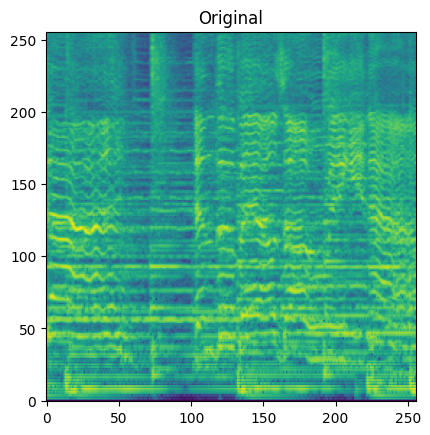

tensor(0.0090) tensor(104.8831)
tensor(0.) tensor(124.5445)
tensor(-1.6550) tensor(1.4525)


In [25]:
### Converting to mel spectrogram and back to audio without enhancement

aux = mel_spec_proc
aux = (aux-aux.min())/(aux.max()-aux.min())
print(aux.min(),aux.max())
rescaled = (aux * (ma-mi)) + mi

plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.show()

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

original_reconstructed = griffinlim(melscaled)
print(original_reconstructed.min(),original_reconstructed.max())

display(Audio(original_reconstructed,rate=16000))

### Enhanced Audio

0.0 0.8


<ipython-input-26-c206c5b8f904>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


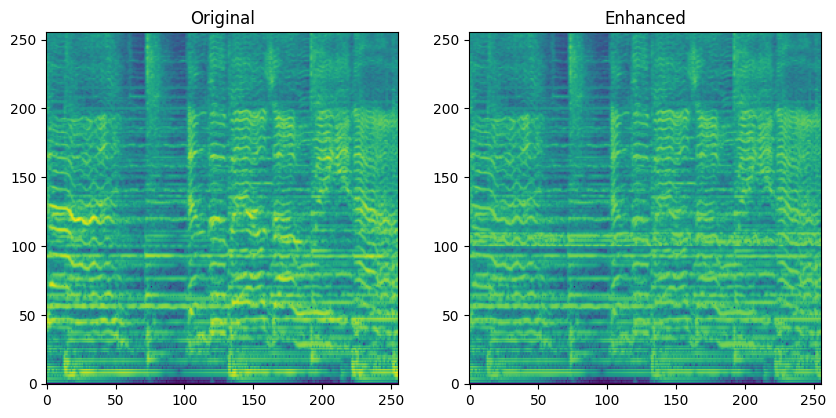

tensor(0.0090) tensor(16.4642)
tensor(0.) tensor(32.2578)
tensor(-0.7918) tensor(0.8596)


In [26]:
### Keeping in range 0.35-0.65

aux = Im_noisy_opt_nlpd.squeeze(-1)
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced')
plt.show()

rescaled = torch.from_numpy((aux * (ma-mi)) + mi)

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Reconstructed Sliced

0.0 0.8012588


<ipython-input-27-d257692def6c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


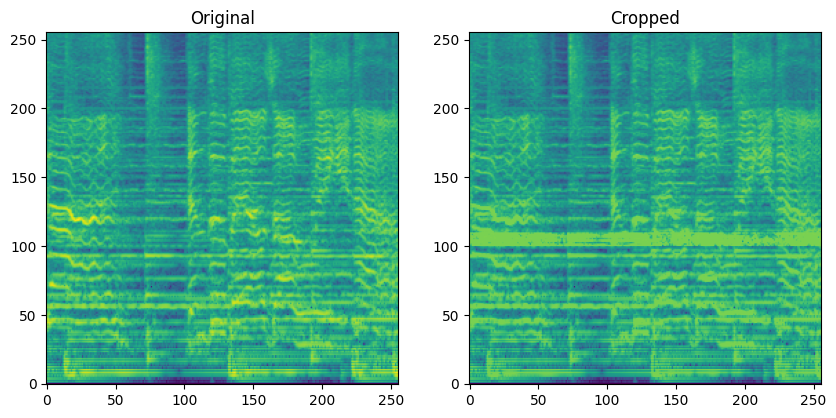

tensor(0.0090) tensor(16.6572)
tensor(0.) tensor(32.6600)
tensor(-1.0671) tensor(1.1647)


In [27]:
aux = Im_noisy_ori.squeeze(-1)
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Cropped')
plt.show()

rescaled = torch.from_numpy((aux * (ma-mi)) + mi)

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Reconstructed Scaled

In [ ]:
rescaled.dtype

torch.float32

tensor(0.5000) tensor(1.)


<ipython-input-128-ed47e1f0d563>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


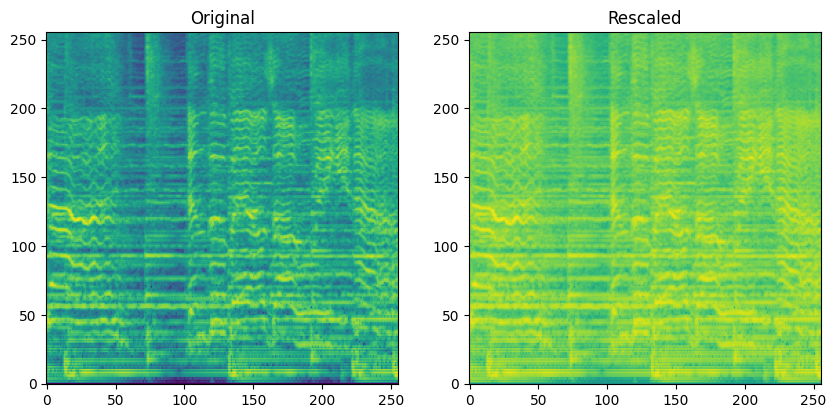

<ipython-input-128-ed47e1f0d563>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rescaled = torch.exp(torch.tensor(rescaled)) - 1e-3


tensor(1.0231) tensor(104.8831)
tensor(0.) tensor(145.2608)
tensor(-3.4276) tensor(3.4788)


In [ ]:
aux = im_scaled
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Rescaled')
plt.show()

rescaled = (aux * (ma-mi)) + mi

rescaled = torch.exp(torch.tensor(rescaled)) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Enhanced & Rescaled

0.1 0.9999654
tensor(0.) tensor(1.)


<ipython-input-46-87b3e2bb1e61>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


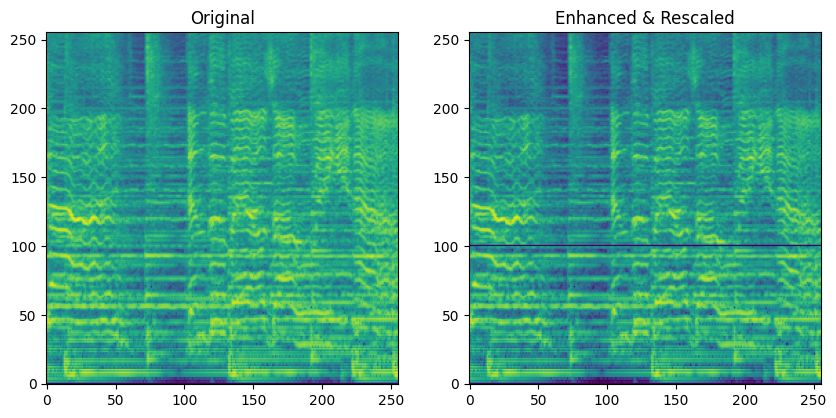

tensor(0.0090) tensor(104.8831)
tensor(0.) tensor(118.5970)
tensor(-1.2974) tensor(1.1883)


In [ ]:
### Rescaling from 0.35-0.65 to 0-1

aux = Im_noisy_opt_nlpd.squeeze(-1)
print(aux.min(),aux.max())

aux = torch.from_numpy((aux-aux.min())/(aux.max()-aux.min()))
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced & Rescaled')
plt.show()

rescaled = (aux * (ma-mi)) + mi

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))